In [71]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt
import pandas as pd
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey
import numpy as np

In [72]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [73]:
Base = automap_base()

In [74]:
Base.prepare(engine, reflect=True)

In [75]:
Base.classes.keys()

['measurement', 'station']

In [76]:
inspector = inspect(engine)

inspector.get_table_names()

['measurement', 'station']

In [77]:
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [78]:
Station = Base.classes.station
Measurements = Base.classes.measurement

In [79]:
session = Session(engine)

In [80]:
last_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
print(last_date)

('2017-08-23',)


In [81]:
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [82]:
rain = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

In [83]:
rain_df = pd.DataFrame(rain)
rain_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [84]:
rain_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


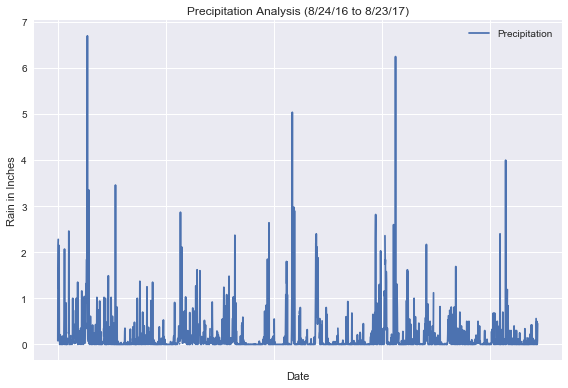

In [85]:
rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Images/precipitation.png')
plt.show()

In [86]:
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [87]:
locations = session.query(Measurements).group_by(Measurements.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [88]:
busy_station = session.query(Measurements.station, func.count(Measurements.tobs)).group_by(Measurements.station).\
               order_by(func.count(Measurements.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in busy_station:
    print("Station",station,"had",count, "weather observations.")

The busiest Station was USC00519281 with 2772 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
Station USC00519281 had 2772 weather observations.
Station USC00519397 had 2724 weather observations.
Station USC00513117 had 2709 weather observations.
Station USC00519523 had 2669 weather observations.
Station USC00516128 had 2612 weather observations.
Station USC00514830 had 2202 weather observations.
Station USC00511918 had 1979 weather observations.
Station USC00517948 had 1372 weather observations.
Station USC00518838 had 511 weather observations.


In [89]:
temperature = session.query(Measurements.station, Measurements.date, Measurements.tobs).\
    filter(Measurements.station == busiest).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

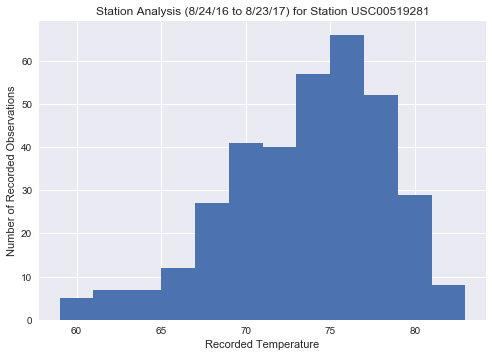

In [90]:
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + busiest)
plt.savefig('Images/station-histogram.png')
plt.show()

In [91]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()
temp_range = (calc_temps('2012-02-28', '2012-03-05'))
print(temp_range)

[(62.0, 69.57142857142857, 74.0)]


In [92]:
trip_arrive = dt.date(2018, 4, 1)
trip_leave = dt.date(2018, 4, 15)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(67.0, 74.47368421052632, 82.0)]


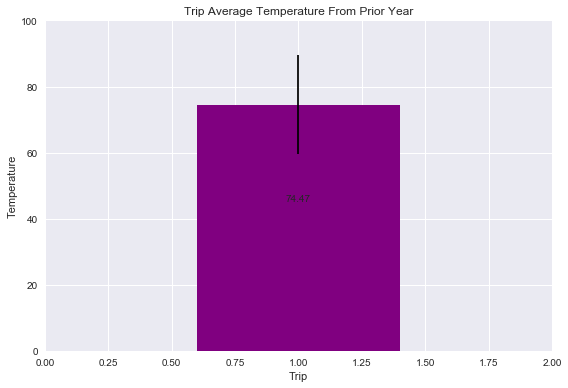

In [93]:
p2p = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'purple', yerr=p2p)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
ax.set_title("Trip Average Temperature From Prior Year")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)

        
    # label the bars 
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.savefig('Images/temperature.png')
plt.show()

In [94]:
lst_year_arrive = trip_arrive - last_year
lst_year_leave = trip_leave - last_year
print(lst_year_arrive)
print(lst_year_leave)

2017-04-01
2017-04-15


In [95]:
vacation_data = session.query(Measurements.station, Measurements.date, Measurements.prcp, Measurements.tobs).\
    filter(Measurements.date >= lst_year_arrive).\
    filter(Measurements.date <= lst_year_leave).\
    order_by(Measurements.station).all()

In [96]:
vacation_data_df=pd.DataFrame(vacation_data)

rain_per_station = pd.pivot_table(vacation_data_df,index=['station'],values=['prcp'], aggfunc=sum)
rain_per_station

,prcp
station,
USC00513117,1.64
USC00514830,0.90
USC00516128,5.75
USC00517948,0.00
USC00519281,4.14
USC00519397,0.27
USC00519523,0.36
